In [1]:
from ast import literal_eval
from os import listdir
from os.path import isfile, join
from scipy.sparse import csr_matrix, load_npz, save_npz
from tqdm import tqdm
import statistics as stats
import seaborn as sns
import datetime
import json
import numpy as np
import pandas as pd
import time
import yaml
import scipy.sparse as sparse
import sys

## Dataset files 

In [2]:
#reviewJson = "..\\data\\Export_CleanedReview.json"
#reviewJsonWithClosedRes = "..\\data\\Export_CleanedReviewWithClosedRes.json"
#reviewJsonToronto = "..\\data\\Export_TorontoData.json"
reviewJsonToronto = "..\\data\\Cleaned_Toronto_Reviews.json"


## Load Data
Select top frenquent user and top frequenty restaurants that had at least 1 review >= 4 stars (Kickking out users that gave all  reviews <=3 and restaurants that never got start >= 4 stars)

In [3]:
def get_yelp_df(path = 'data/', filename = 'Export_CleanedReview.json', sampling=False, top_user_num=7000, top_item_num=5000):
    """
    Get the pandas dataframe
    Sampling only the top users/items by density 
    Implicit representation applies
    """
    with open(filename,'r') as f:
        data = f.readlines()
        data = list(map(json.loads, data))
    
    data = data[0]
    #Get all the data from the dggeata file
    df = pd.DataFrame(data)
    
    df.rename(columns={'stars': 'review_stars', 'text': 'review_text', 'cool': 'review_cool',
                       'funny': 'review_funny', 'useful': 'review_useful'},
              inplace=True)

    df['business_num_id'] = df.business_id.astype('category').\
        cat.rename_categories(range(0, df.business_id.nunique()))
    df['business_num_id'] = df['business_num_id'].astype('int')

    df['user_num_id'] = df.user_id.astype('category').\
    cat.rename_categories(range(0, df.user_id.nunique()))
    df['user_num_id'] = df['user_num_id'].astype('int')

    df['timestamp'] = df['date'].apply(date_to_timestamp)

    if sampling:
        df = filter_yelp_df(df, top_user_num=top_user_num, top_item_num=top_item_num)
        # Refresh num id
        df['business_num_id'] = df.business_id.astype('category').\
        cat.rename_categories(range(0, df.business_id.nunique()))
        df['business_num_id'] = df['business_num_id'].astype('int')
        
        df['user_num_id'] = df.user_id.astype('category').\
        cat.rename_categories(range(0, df.user_id.nunique()))
        df['user_num_id'] = df['user_num_id'].astype('int')
#     drop_list = ['date','review_id','review_funny','review_cool','review_useful']
#     df = df.drop(drop_list, axis=1)

    df = df.reset_index(drop = True)

    return df 

def filter_yelp_df(df, top_user_num=7000, top_item_num=5000):
    #Getting the reviews where starts are above 3
    df_implicit = df[df['review_stars']>3]
    frequent_user_id = df_implicit['user_num_id'].value_counts().head(top_user_num).index.values
    frequent_item_id = df_implicit['business_num_id'].value_counts().head(top_item_num).index.values
    return df.loc[(df['user_num_id'].isin(frequent_user_id)) & (df['business_num_id'].isin(frequent_item_id))]

def date_to_timestamp(date):
    dt = datetime.datetime.strptime(date, '%Y-%m-%d')
    return time.mktime(dt.timetuple())

def df_to_sparse(df, row_name='userId', col_name='movieId', value_name='rating',
                 shape=None):
    rows = df[row_name]
    cols = df[col_name]
    if value_name is not None:
        values = df[value_name]
    else:
        values = [1]*len(rows)

    return csr_matrix((values, (rows, cols)), shape=shape)

## Get rating-UI and timestamp-UI matrix from original df

In [4]:
def get_rating_timestamp_matrix(df, sampling=False, top_user_num=7000, top_item_num=5000):
    """
    """
    #make the df implicit with top frenquent users and 
    #no need to sample anymore if df was sampled before 
    if sampling:
        df = filter_yelp_df(df, top_user_num=top_user_num, top_item_num=top_item_num)

    rating_matrix = df_to_sparse(df, row_name='user_num_id',
                                 col_name='business_num_id',
                                 value_name='review_stars',
                                 shape=None)
    
    #Have same dimension and data entries with rating_matrix, except that the review stars are - user avg
#     ratingWuserAvg_matrix = df_to_sparse(df, row_name='user_num_id',
#                                  col_name='business_num_id',
#                                  value_name='reviewStars_userAvg',
#                                  shape=None)
    
    timestamp_matrix = df_to_sparse(df, row_name='user_num_id',
                                    col_name='business_num_id',
                                    value_name='timestamp',
                                    shape=None)
    
    
    IC_matrix, IC_dictionary = get_I_C(df)
#     ratingWuserAvg_matrix
    return rating_matrix, timestamp_matrix, IC_matrix, IC_dictionary

In [5]:
def get_I_C(df):
    lst = df.categories.values.tolist()
    cat = []
    for i in range(len(lst)):
        if lst[i] is None:
            print(i)
        cat.extend(lst[i].split(', '))
        
    unique_cat = set(cat)
    #     set categories id
    df_cat = pd.DataFrame(list(unique_cat),columns=["Categories"])
    df_cat['cat_id'] = df_cat.Categories.astype('category').cat.rename_categories(range(0, df_cat.Categories.nunique()))
    dict_cat = df_cat.set_index('Categories')['cat_id'].to_dict()
    
    df_I_C = pd.DataFrame(columns=['business_num_id', 'cat_id'])
    
    for i in range((df['business_num_id'].unique().shape)[0]):
        df_temp = df[df['business_num_id'] == i].iloc[:1]
        temp_lst = df_temp['categories'].to_list()[0].split(",")
        for j in range(len(temp_lst)):
            df_I_C = df_I_C.append({'business_num_id' : i  , 'cat_id' : dict_cat[temp_lst[j].strip()]} , ignore_index=True)
    
    IC_Matrix = df_to_sparse(df_I_C, row_name='business_num_id',
                                 col_name='cat_id',
                                 value_name=None,
                                 shape=None)    
    return IC_Matrix, dict_cat

## Time ordered split 

In [6]:
def time_ordered_splitModified(rating_matrix, ratingWuserAvg_matrix, timestamp_matrix, ratio=[0.5, 0.2, 0.3],
                       implicit=True, remove_empty=False, threshold=3,
                       sampling=False, sampling_ratio=0.1, trainSampling=1):
    """
    Split the data to train,valid,test by time
    ratio:  train:valid:test
    threshold: for implicit representation
    """
    
    
    if implicit:
        temp_rating_matrix = sparse.csr_matrix(rating_matrix.shape)
        temp_rating_matrix[(rating_matrix > threshold).nonzero()] = 1
        rating_matrix = temp_rating_matrix
        timestamp_matrix = timestamp_matrix.multiply(rating_matrix)
        #ratingWuserAvg_matrix = ratingWuserAvg_matrix.multiply(rating_matrix)

    nonzero_index = None

    #Default false, not removing empty columns and rows
    #Should not have this case, since users should have at least 1 record of 4,5 
    #And restuarant should have at least 1 record of 4,5 
    if remove_empty:
        # Remove empty columns. record original item index
        nonzero_index = np.unique(rating_matrix.nonzero()[1])
        rating_matrix = rating_matrix[:, nonzero_index]
        timestamp_matrix = timestamp_matrix[:, nonzero_index]
        ratingWuserAvg_matrix = ratingWuserAvg_matrix[:, nonzero_index]

        # Remove empty rows. record original user index
        nonzero_rows = np.unique(rating_matrix.nonzero()[0])
        rating_matrix = rating_matrix[nonzero_rows]
        timestamp_matrix = timestamp_matrix[nonzero_rows]
        ratingWuserAvg_matrix = ratingWuserAvg_matrix[nonzero_rows]

    user_num, item_num = rating_matrix.shape

    rtrain = []
    rtrain_userAvg = []
    rtime = []
    rvalid = []
    rvalid_userAvg = []
    rtest = []
    rtest_userAvg = []
    # Get the index list corresponding to item for train,valid,test
    item_idx_train = []
    item_idx_valid = []
    item_idx_test = []
    
    for i in tqdm(range(user_num)):
        #Get the non_zero indexs, restuarants where the user visited/liked if implicit 
        item_indexes = rating_matrix[i].nonzero()[1]        
        #Get the data for the user
        data = rating_matrix[i].data      
        #Get time stamp value 
        timestamp = timestamp_matrix[i].data 
        #Get review stars with user avg data 
        if implicit == False:
            dataWuserAvg = ratingWuserAvg_matrix[i].data

            
        #Non zero reviews for this user
        num_nonzeros = len(item_indexes)
        
        #If the user has at least one review
        if num_nonzeros >= 1:
            num_test = int(num_nonzeros * ratio[2])
            num_valid = int(num_nonzeros * (ratio[1] + ratio[2]))
            valid_offset = num_nonzeros - num_valid
            
            # Adding this for sampling for training set
            valid_offsetSample = int(valid_offset*trainSampling)
            test_offset = num_nonzeros - num_test
            
            #Sort the timestamp for each review for the user
            argsort = np.argsort(timestamp)
            
            #Sort the reviews for the user according to the time stamp 
            data = data[argsort]
            
            #Sort the review with user avg accoridng to the time stamp
            if implicit == False:
                dataWuserAvg = dataWuserAvg[argsort]
            
            #Non-zero review index sort according to time
            item_indexes = item_indexes[argsort]
            
            #list of ratings, num of valid_offset index, index where there's non-zeros
            #if take from old to new
            #rtrain.append([data[:valid_offsetSample], np.full(valid_offsetSample, i), item_indexes[:valid_offsetSample]])
            #if take from new to old
            rtrain.append([data[valid_offset-valid_offsetSample:valid_offset], np.full(valid_offsetSample, i), item_indexes[valid_offset-valid_offsetSample:valid_offset]])
            rvalid.append([data[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
                           item_indexes[valid_offset:test_offset]])
            rtest.append([data[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])
            
            if implicit == False:
                #Now for the rating matrix that considers user average rating
                #list of ratings, num of valid_offset index, index where there's non-zeros
                #from old to new
                #rtrain_userAvg.append([dataWuserAvg[:valid_offsetSample], np.full(valid_offsetSample, i), item_indexes[:valid_offsetSample]])
                #take nearest
                rtrain_userAvg.append([dataWuserAvg[valid_offset-valid_offsetSample:valid_offset], np.full(valid_offsetSample, i), item_indexes[valid_offset-valid_offsetSample:valid_offset]])                
                    
                rvalid_userAvg.append([dataWuserAvg[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
                               item_indexes[valid_offset:test_offset]])
                
                rtest_userAvg.append([dataWuserAvg[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])
                
            item_idx_train.append(item_indexes[:valid_offsetSample])
            item_idx_valid.append(item_indexes[:test_offset])
            item_idx_test.append(item_indexes[test_offset:])
            
        else:
            item_idx_train.append([])
    
    rtrain = np.array(rtrain)
    rvalid = np.array(rvalid)
    rtest = np.array(rtest)
   
    if implicit == False:
        rtrain_userAvg = np.array(rtrain_userAvg)
        rvalid_userAvg = np.array(rvalid_userAvg)
        rtest_userAvg = np.array(rtest_userAvg)

    #take non-zeros values, row index, and column (non-zero) index and store into sparse matrix
    rtrain = sparse.csr_matrix((np.hstack(rtrain[:, 0]), (np.hstack(rtrain[:, 1]), np.hstack(rtrain[:, 2]))),
                               shape=rating_matrix.shape, dtype=np.float32)
    rvalid = sparse.csr_matrix((np.hstack(rvalid[:, 0]), (np.hstack(rvalid[:, 1]), np.hstack(rvalid[:, 2]))),
                               shape=rating_matrix.shape, dtype=np.float32)
    rtest = sparse.csr_matrix((np.hstack(rtest[:, 0]), (np.hstack(rtest[:, 1]), np.hstack(rtest[:, 2]))),
                              shape=rating_matrix.shape, dtype=np.float32)
    
    if implicit == False:
        rtrain_userAvg = sparse.csr_matrix((np.hstack(rtrain_userAvg[:, 0]), (np.hstack(rtrain_userAvg[:, 1]), np.hstack(rtrain_userAvg[:, 2]))),
                                   shape=rating_matrix.shape, dtype=np.float32)
        rvalid_userAvg = sparse.csr_matrix((np.hstack(rvalid_userAvg[:, 0]), (np.hstack(rvalid_userAvg[:, 1]), np.hstack(rvalid_userAvg[:, 2]))),
                                   shape=rating_matrix.shape, dtype=np.float32)
        rtest_userAvg = sparse.csr_matrix((np.hstack(rtest_userAvg[:, 0]), (np.hstack(rtest_userAvg[:, 1]), np.hstack(rtest_userAvg[:, 2]))),
                                  shape=rating_matrix.shape, dtype=np.float32)

    return rtrain, rvalid, rtest,rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, timestamp_matrix, item_idx_train, item_idx_valid, item_idx_test


### Popularity Calculation

In [7]:
def get_three_popularity_matrix(df_original,rtrain):
    # get the list of popular items by ranking the number of reviews
    numUsers = rtrain.shape[0]
    numItems = rtrain.shape[1]
    
    dff_popular = df_original.copy()
    dff_popular = dff_popular.sort_values(by=["review_count_y"], ascending=False).drop_duplicates(subset = 'business_id', keep = 'first')
    popular_list_num_of_reviews = dff_popular["business_num_id"].tolist()
    
    # get the list of popular items by ranking average rating score
    dff_popular_rating = df_original.copy()
    dff_popular_rating = dff_popular_rating.sort_values(by=["business_stars"], ascending=False).drop_duplicates(subset = 'business_id', keep = 'first')
    popular_list_avg_stars = dff_popular_rating["business_num_id"].tolist()
    
    lst_temp = []
    for item in tqdm(range(numItems)):
        numOfUsersRated = len(rtrain.toarray()[:, item].nonzero()[0])
        if numOfUsersRated <= 50:
            lst_temp.append(item)
    popular_list_avg_stars = [x for x in popular_list_avg_stars if x not in lst_temp]
    
    # get the popularity items by using the percentage liked method(number of liked items / total items)
    predictionMatrix = np.zeros((numUsers , numItems))

    # Define function for converting 1-5 rating to 0/1 (like / don't like)
    vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    rtrain_array = rtrain.toarray()
    # For every item calculate the number of people liked (4-5) divided by the number of people that rated
    itemPopularity = np.zeros((numItems))
    for item in range(numItems):
        numOfUsersRated = len(rtrain_array[:, item].nonzero()[0])
        numOfUsersLiked = len(vf(rtrain_array[:, item]).nonzero()[0])
#         if numOfUsersRated == 0:
        # set a threshold to filter out restaurants with very few reviews
        if numOfUsersRated <= 30:
            itemPopularity[item] = 0
        else:
            itemPopularity[item] = numOfUsersLiked/numOfUsersRated
    popular_list_liked_ratio = itemPopularity.argsort()
    
    return np.asarray(popular_list_num_of_reviews),np.asarray(popular_list_avg_stars),popular_list_liked_ratio

## Get df for training corpus

In [8]:
#Item idex matrix stores the reivews starts
#This function returns a list of index for the reviews included in training set 
def get_corpus_idx_list(df, item_idx_matrix):
    """
    Input: 
    df: total dataframe
    item_idx_matrix: train index list got from time_split 
    Output: row index in original dataframe for training data by time split
    """
    lst = []
    #For all the users: 5791
    for i in tqdm(range(len(item_idx_matrix))):
        
        #find row index where user_num_id is i
        a = df.index[df['user_num_id'] == i].tolist()
        
        #loop through the busienss id that the user i reviewed for in offvalid set 
        for item_idx in  item_idx_matrix[i]:
            
            #get the row index for reviews for business that the user liked in the train set
            b = df.index[df['business_num_id'] == item_idx].tolist()
            
            #Find the index for which this user liked, one user only rate a business once
            idx_to_add = list(set(a).intersection(b))
            
            if idx_to_add not in lst:
                lst.extend(idx_to_add)
    return lst

## Preprocess using Term Frequency - CounterVectorizer

In [9]:
#Stemming and Lemmatisation
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
# Get corpus and CountVector
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('wordnet')
nltk.download('stopwords')
lem = WordNetLemmatizer()
stem = PorterStemmer()
stop_words = set(stopwords.words("english"))
new_words = ['not_the']
stop_words = stop_words.union(new_words)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shenti10\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shenti10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from tqdm import tqdm

#Should 'because' added?
def preprocess(df, reset_list = [',','.','?',';','however','but']):
    corpus = []
    for i in tqdm(range(df.shape[0])):
        text = df['review_text'][i]
        change_flg = 0
        #Convert to lowercase
        text = text.lower()
        
        ##Convert to list from string, loop through the review text
        text = text.split()
        
        #any sentence that encounters a not, the folloing words will become not phrase until hit the sentence end
        for j in range(len(text)):
            #Make the not_ hack
            if text[j] == 'not':
                change_flg = 1
#                 print 'changes is made after ', i
                continue
            #if was 1 was round and not hit a 'not' in this round
            if change_flg == 1 and any(reset in text[j] for reset in reset_list):
                text[j] = 'not_' + text[j]
                change_flg = 0
#                 print 'reset at ', i
            if change_flg == 1:
                text[j] = 'not_' + text[j]
        
        #Convert back to string
        text = " ".join(text)
        
        #Remove punctuations
#       text = re.sub('[^a-zA-Z]', ' ', text)
        
        #remove tags
        text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
        
        # remove special characters and digits
        text=re.sub("(\\d|\\W)+"," ",text)
        
        ##Convert to list from string
        text = text.split()
        
        ##Stemming
        ps=PorterStemmer()
        
        #Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in  
                stop_words] 
        text = " ".join(text)
        corpus.append(text)
    return corpus

## All Model

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
def train(matrix_train):
    similarity = cosine_similarity(X=matrix_train, Y=None, dense_output=True)
    return similarity

def get_I_K(df, X, row_name = 'business_num_id', binary = True, shape = (121994,6000)):
    """
    get the item-keyphrase matrix
    """
    rows = []
    cols = []
    vals = []
    #For each review history
    for i in tqdm(range(X.shape[0])):
        #Get the array of frequencies for document/review i 
        arr = X[i].toarray() 
        nonzero_element = arr.nonzero()[1]  # Get nonzero element in each line, keyphrase that appears index 
        length_of_nonzero = len(nonzero_element) #number of important keyphrase that appears
        
        # df[row_name][i] is the item idex
        #Get a list row index that indicates the document/review
        rows.extend(np.array([df[row_name][i]]*length_of_nonzero)) ## Item index
        #print(rows)
        
        #Get a list of column index indicating the key phrase that appears in i document/review
        cols.extend(nonzero_element) ## Keyword Index
        if binary:
            #Create a bunch of 1s
            vals.extend(np.array([1]*length_of_nonzero))
        else:
            #If not binary 
            vals.extend(arr[arr.nonzero()])    
    return csr_matrix((vals, (rows, cols)), shape=shape)


#Get a UI matrix if it's not item_similarity based or else IU
def predict(matrix_train, k, similarity, item_similarity_en = False):
    prediction_scores = []
    
    #inverse to IU matrix
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    #for each user or item, depends UI or IU 
    for user_index in tqdm(range(matrix_train.shape[0])):
        # Get user u's prediction scores for all items
        #Get prediction/similarity score for each user 1*num or user or num of items
        vector_u = similarity[user_index]

        # Get closest K neighbors excluding user u self
        #Decending accoding to similarity score, select top k
        similar_users = vector_u.argsort()[::-1][1:k+1]
        
        # Get neighbors similarity weights and ratings
        similar_users_weights = similarity[user_index][similar_users]
        
        #similar_users_weights_sum = np.sum(similar_users_weights)
        #print(similar_users_weights.shape)
        #shape: num of res * k
        similar_users_ratings = matrix_train[similar_users].toarray()
              
        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
        #print(prediction_scores_u)
        
        
        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    return res


#Preidction score is UI or IU?
def prediction(prediction_score, topK, matrix_Train):

    prediction = []

    #for each user
    for user_index in tqdm(range(matrix_Train.shape[0])):
        
        #take the prediction scores for user 1 * num res
        vector_u = prediction_score[user_index]
        
        #The restuarant the user rated
        vector_train = matrix_Train[user_index]
        
        if len(vector_train.nonzero()[0]) > 0:
            vector_predict = sub_routine(vector_u, vector_train, topK=topK)
        else:
            vector_predict = np.zeros(topK, dtype=np.float32)

        prediction.append(vector_predict)

    return np.vstack(prediction)

def prediction_modified(prediction_score, matrix_Train, user_id, topK = 50):
    prediction = []

    #for each user
    for user_index in tqdm(range(matrix_Train.shape[0])):
        
        #take the prediction scores for user 1 * num res
        vector_u = prediction_score[user_index]
        
        #The restuarant the user rated
        vector_train = matrix_Train[user_index]
        
        if len(vector_train.nonzero()[0]) > 0:
            vector_predict = sub_routine_modified(vector_u, vector_train)
        else:
            vector_predict = np.zeros(topK, dtype=np.float32)

        prediction.append(vector_predict)

    return prediction[user_id]

#topK: the number of restuarants we are suggesting 
#if vector_train has number, then the user has visited
def sub_routine(vector_u, vector_train, topK=500):

    #index where non-zero
    train_index = vector_train.nonzero()[1]
    
    vector_u = vector_u
    
    #get topk + num rated res prediction score descending, top index 
    candidate_index = np.argpartition(-vector_u, topK+len(train_index))[:topK+len(train_index)]
    
    #sort top prediction score index in range topK+len(train_index) into vector_u`
    vector_u = candidate_index[vector_u[candidate_index].argsort()[::-1]]
    
    #deleted the rated res from the topk+train_index prediction score vector for user u 
    #Delete the user rated res index from the topk+numRated index
    vector_u = np.delete(vector_u, np.isin(vector_u, train_index).nonzero()[0])

    #so we only include the top K prediction score here
    return vector_u[:topK]

def sub_routine_modified(vector_u, vector_train):

    #index where non-zero
    train_index = vector_train.nonzero()[1]
    
    vector_u = vector_u
    
    #get topk + num rated res prediction score descending, top index 
    candidate_index = np.argpartition(-vector_u, -1)
    
    #sort top prediction score index in range topK+len(train_index) into vector_u`
    vector_u = candidate_index[vector_u[candidate_index].argsort()[::-1]]
    
    #deleted the rated res from the topk+train_index prediction score vector for user u 
    #Delete the user rated res index from the topk+numRated index
    vector_u = np.delete(vector_u, np.isin(vector_u, train_index).nonzero()[0])

    #so we only include the top K prediction score here
    return vector_u

## Evaluation

In [12]:
def recallk(vector_true_dense, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_true_dense)


def precisionk(vector_predict, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_predict)


def average_precisionk(vector_predict, hits, **unused):
    precisions = np.cumsum(hits, dtype=np.float32)/range(1, len(vector_predict)+1)
    return np.mean(precisions)


def r_precision(vector_true_dense, vector_predict, **unused):
    vector_predict_short = vector_predict[:len(vector_true_dense)]
    hits = len(np.isin(vector_predict_short, vector_true_dense).nonzero()[0])
    return float(hits)/len(vector_true_dense)


def _dcg_support(size):
    arr = np.arange(1, size+1)+1
    return 1./np.log2(arr)


def ndcg(vector_true_dense, vector_predict, hits):
    idcg = np.sum(_dcg_support(len(vector_true_dense)))
    dcg_base = _dcg_support(len(vector_predict))
    dcg_base[np.logical_not(hits)] = 0
    dcg = np.sum(dcg_base)
    return dcg/idcg


def click(hits, **unused):
    first_hit = next((i for i, x in enumerate(hits) if x), None)
    if first_hit is None:
        return 5
    else:
        return first_hit/10


def evaluate(matrix_Predict, matrix_Test, metric_names =['R-Precision', 'NDCG', 'Precision', 'Recall', 'MAP'], atK = [5, 10, 15, 20, 50], analytical=False):
    """
    :param matrix_U: Latent representations of users, for LRecs it is RQ, for ALSs it is U
    :param matrix_V: Latent representations of items, for LRecs it is Q, for ALSs it is V
    :param matrix_Train: Rating matrix for training, features.
    :param matrix_Test: Rating matrix for evaluation, true labels.
    :param k: Top K retrieval
    :param metric_names: Evaluation metrics
    :return:
    """
    global_metrics = {
        #"R-Precision": r_precision,
        #"NDCG": ndcg,
        #"Clicks": click
    }

    local_metrics = {
        #"Precision": precisionk,
        #"Recall": recallk,
        "MAP": average_precisionk
    }

    output = dict()

    num_users = matrix_Predict.shape[0]

    for k in atK:

        local_metric_names = list(set(metric_names).intersection(local_metrics.keys()))
        results = {name: [] for name in local_metric_names}
        topK_Predict = matrix_Predict[:, :k]

        for user_index in tqdm(range(topK_Predict.shape[0])):
            vector_predict = topK_Predict[user_index]
            if len(vector_predict.nonzero()[0]) > 0:
                vector_true = matrix_Test[user_index]
                vector_true_dense = vector_true.nonzero()[1]
                hits = np.isin(vector_predict, vector_true_dense)

                if vector_true_dense.size > 0:
                    for name in local_metric_names:
                        results[name].append(local_metrics[name](vector_true_dense=vector_true_dense,
                                                                 vector_predict=vector_predict,
                                                                 hits=hits))
        results_summary = dict()
        if analytical:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = round(results[name],4)
        else:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = (round((np.average(results[name])),4),
                                                              round((1.96*np.std(results[name])/np.sqrt(num_users)),4))
        output.update(results_summary)

    global_metric_names = list(set(metric_names).intersection(global_metrics.keys()))
    results = {name: [] for name in global_metric_names}

    topK_Predict = matrix_Predict[:]

    for user_index in tqdm(range(topK_Predict.shape[0])):
        vector_predict = topK_Predict[user_index]

        if len(vector_predict.nonzero()[0]) > 0:
            vector_true = matrix_Test[user_index]
            vector_true_dense = vector_true.nonzero()[1]
            hits = np.isin(vector_predict, vector_true_dense)

            # if user_index == 1:
            #     import ipdb;
            #     ipdb.set_trace()

            if vector_true_dense.size > 0:
                for name in global_metric_names:
                    results[name].append(global_metrics[name](vector_true_dense=vector_true_dense,
                                                              vector_predict=vector_predict,
                                                              hits=hits))
    results_summary = dict()
    if analytical:
        for name in global_metric_names:
            results_summary[name] = round(results[name],4)
    else:
        for name in global_metric_names:
            results_summary[name] = (round(np.average(results[name]),4), round((1.96*np.std(results[name])/np.sqrt(num_users)),4))
    output.update(results_summary)

    return output

#### Get original dataframe out of the review datastet

In [13]:
df = get_yelp_df(path ='', filename=reviewJsonToronto, sampling= True)

In [14]:
df.shape[0]

205968

### Investigating the cities

In [15]:
# np.set_printoptions(threshold=sys.maxsize)
# listCity = []
# for location in df.location.unique():
#     city = yaml.safe_load(location)['city']
#     if city not in listCity:
#         listCity.append(city)
# listCity

In [16]:
df.head(2)

,Day,Month,Unnamed: 0.1,Unnamed: 0_x,Unnamed: 0_y,Updated,Year,alias,business_id,business_stars,...,review_text,transactions,ufc,url,user_id,user_loc,vote_count,business_num_id,user_num_id,timestamp
0,23,8,6,6,21653,False,2016,happy-lemon-markham,Xo1LNzhnwE-ilqsM3ybs9Q,3.5,...,I ordered the lemon mango slush and the lemon ...,[],"[1, 1, 1]",https://www.yelp.com/biz/happy-lemon-markham?a...,zsJFjhBQEFQ6gJ7BsNM_Ug,"Toronto, Canada",1.0,2682,6984,1.471925e+09
1,2,10,7,7,21653,False,2016,happy-lemon-markham,Xo1LNzhnwE-ilqsM3ybs9Q,3.5,...,"Came here on a Sunday afternoon, it wasn't bus...",[],"[1, 0, 0]",https://www.yelp.com/biz/happy-lemon-markham?a...,P7YuMh74-I2cDq7oU8frww,"York Regional Municipality, Canada",1.0,2682,2845,1.475381e+09


#### Get rating-UI matrix and timestepm-UI matrix

In [17]:
rating_matrix, timestamp_matrix , I_C_matrix, IC_dictionary = get_rating_timestamp_matrix(df)

# get ratingWuserAvg_matrix
rating_array = rating_matrix.toarray()
user_average_array = rating_array.sum(axis = 1)/np.count_nonzero(rating_array,axis = 1)
init_UI = np.zeros(rating_array.shape)
init_UI[rating_array.nonzero()] = 1

for i in range(user_average_array.shape[0]):
    init_UI[i] = init_UI[i] * (user_average_array[i]-0.001) 
user_average_array = init_UI
ratingWuserAvg_array = rating_array - user_average_array
ratingWuserAvg_matrix=sparse.csr_matrix(ratingWuserAvg_array)

In [18]:
IC_dictionary

{'Dive Bars': 71,
 'Australian': 11,
 'Sri Lankan': 192,
 'Smokehouse': 181,
 'Tiki Bars': 207,
 'Colombian': 55,
 'Cocktail Bars': 52,
 'Filipino': 82,
 'Brasseries': 25,
 'Polish': 160,
 'Himalayan/Nepalese': 104,
 'Laotian': 128,
 'Hot Pot': 108,
 'Music Venues': 142,
 'Art Galleries': 8,
 'Spanish': 187,
 'Pubs': 165,
 'Tabletop Games': 199,
 'Internet Cafes': 116,
 'Imported Food': 112,
 'Chicken Shop': 46,
 'Comedy Clubs': 56,
 'Persian/Iranian': 153,
 'Gastropubs': 92,
 'Wine Tours': 222,
 'Ukrainian': 211,
 'Live/Raw Food': 131,
 'Tours': 209,
 'Burgers': 33,
 'Wine & Spirits': 220,
 'Sports Clubs': 191,
 'Juice Bars & Smoothies': 122,
 'Whiskey Bars': 219,
 'Southern': 186,
 'Bagels': 13,
 'Coffee & Tea': 53,
 'Sushi Bars': 197,
 'Acai Bowls': 0,
 'Czech': 63,
 'Butcher': 34,
 'Cideries': 50,
 'Nightlife': 145,
 'Dance Clubs': 64,
 'Antiques': 4,
 'Kosher': 127,
 'Street Vendors': 194,
 'Patisserie/Cake Shop': 151,
 'Delis': 66,
 'Food Court': 86,
 'Cantonese': 40,
 'Belgian':

#### Split to get rtrain-UI matrix and valid and test.. item_index_matrix_train

In [19]:
rtrain_implicit, rvalid_implicit, rtest_implicit, rtrain_userAvg_implicit, rvalid_userAvg_implicit, rtest_userAvg_implicit, nonzero_index, rtime, item_idx_matrix_train_implicit,item_idx_matrix_valid_implicit, item_idx_matrix_test_implicit = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=True,
                                                                     remove_empty=False, threshold=3,sampling=False, 
                                                                     sampling_ratio=0.1, trainSampling=0.95)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  del sys.path[0]
100%|████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:01<00:00, 5347.66it/s]


In [20]:
rtrain, rvalid, rtest, rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, rtime, item_idx_matrix_train,item_idx_matrix_valid, item_idx_matrix_test = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=False,
                                                                     remove_empty=False, threshold=3,
                                                                     sampling=False, sampling_ratio=0.1, 
                                                                     trainSampling=0.95)  

100%|████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:01<00:00, 4148.20it/s]


### Using entire dataset 

In [21]:
rtrain = rtrain + rvalid + rtest

In [22]:
rtrain_implicit = rtrain_implicit + rvalid_implicit + rtest_implicit

### Using TD-IDF to compute corpus and X (business vs. terms) TfIdfVectorizer

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
corpus = preprocess(df)

100%|████████████████████████████████████████████████████████████████████████| 205968/205968 [01:10<00:00, 2919.95it/s]


In [25]:
#Creating a dictionary to store business: review text
dict_text = {}
for i in range(len(corpus)):
    if df['business_num_id'][i] not in dict_text:
        dict_text[df['business_num_id'][i]] = corpus[i]
    else:
        temp = dict_text[df['business_num_id'][i]]
        temp = temp + corpus[i]
        dict_text[df['business_num_id'][i]] = temp

In [26]:
#Create a list for the review text, where the row dimension = total business ids
list_text = []
for key in range(0,max(list(dict_text.keys()))+1) :
    if key not in dict_text.keys():
        list_text.extend([""])
    else:
        list_text.extend([dict_text[key]])

In [27]:
#Get the X vector, where dimension is #business vs #terms like IK
vectorizer = TfidfVectorizer(max_df=0.9,stop_words=stop_words, max_features=5000, ngram_range=(1,1))
X_cleaned = vectorizer.fit_transform(list_text).toarray()
X_cleaned_sparse = csr_matrix(X_cleaned)

In [28]:
#Check keywords
#print(vectorizer.get_feature_names())
#keywordList = X_cleaned_sparse[50].nonzero()[1]
#for word in keywordList:
#    print(vectorizer.get_feature_names()[word])

## Cross Validation Section below

In [29]:
#Passing in the trained similarity matrx
def individualKNNPrediction (similarityMatrix, predictionMatrix, kRange, validOrTestMatrix, itemBased=False):
    "Declaration for kRange = range(50,120,10)"
    #similarity = train(similarityMatrix)
    MAP10 = {}
    #Loop through the kvalues 
    for kValue in kRange:
        if(itemBased==False):
            user_item_p
            rediction_score = predict(predictionMatrix, kValue, similarityMatrix, item_similarity_en= False)
        else:
            user_item_prediction_score = predict(predictionMatrix, kValue, similarityMatrix, item_similarity_en= True)
        user_item_predict = prediction(user_item_prediction_score, 50, predictionMatrix)
        user_item_res = evaluate(user_item_predict, validOrTestMatrix)
        
        
        MAP10[kValue] = user_item_res.get('MAP@10')
        
    return MAP10

def get_UC_Matrix(IC_Matrix,rtrain_implicit):
    U_C_matrix_explicit = rtrain_implicit*IC_Matrix
    U_C_matrix_implicit = getImplicitMatrix(U_C_matrix_explicit,3)
    return U_C_matrix_explicit,U_C_matrix_implicit

def getImplicitMatrix(sparseMatrix, threashold=0):
    temp_matrix = sparse.csr_matrix(sparseMatrix.shape)
    temp_matrix[(sparseMatrix > threashold).nonzero()] = 1
    return temp_matrix

In [30]:
#Passing in the trained similarity matrx
def KNNPrediction (similarityMatrix, predictionMatrix, kValue, validOrTestMatrix, itemBased=False):

    if(itemBased==False):
        user_item_prediction_score = predict(predictionMatrix, kValue, similarityMatrix, item_similarity_en= False)
    else:
        user_item_prediction_score = predict(predictionMatrix, kValue, similarityMatrix, item_similarity_en= True)
    user_item_predict = prediction(user_item_prediction_score, 50, predictionMatrix)
    user_item_res = evaluate(user_item_predict, validOrTestMatrix)

        
    return user_item_res.get('MAP@10')

In [31]:
def saveDictToJson(dictionary, fileName, trainOrTest='train'):
    json_fileName = "{:s}.json".format(fileName)
    if(trainOrTest == 'train'):
        json.dump(dictionary, open("crossValidation\\trainPerformance\\"+json_fileName, 'w') )
    else:
        json.dump(dictionary, open("crossValidation\\testPerformance\\"+json_fileName, 'w') )
    

def loadDict(fileName, trainOrTest='train'):
    json_fileName = "{:s}.json".format(fileName)
    # Read data from file:
    if(trainOrTest == 'train'):
        dataDict = json.load( open("crossValidation\\trainPerformance\\"+json_fileName))
    else:
        dataDict = json.load( open("crossValidation\\testPerformance\\"+json_fileName))
    return dataDict

In [32]:
#Get UC matrices
U_C_matrix_explicit,U_C_matrix_implicit = get_UC_Matrix(I_C_matrix,rtrain_implicit)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [33]:
#Get User visit binary UI matrix
#userVisitMatrix = getImplicitMatrix(rtrain)

In [34]:
U_C_matrix_implicit.shape

(7000, 224)

## Item based recommend & critique

In [35]:
#IK TF-IDF
IK_MATRIX = X_cleaned_sparse
IK_similarity = train(IK_MATRIX)
IC_similarity = train(I_C_matrix)

In [36]:
I_C_matrix.shape

(4996, 224)

In [37]:
#IK TF-IDF
#testPerformance['ItemKeyphrase'] = KNNPrediction(IK_similarity, rtrain, 110, rtest, itemBased=True)
user_item_prediction_score = predict(rtrain, 110, IK_similarity, item_similarity_en= True)
user_item_predict = prediction(user_item_prediction_score, 50, rtrain)

100%|████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:01<00:00, 3521.64it/s]


In [38]:
all_user_item_predict = prediction_modified(user_item_prediction_score, rtrain, 23)
all_user_item_predict[:50]

100%|████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:04<00:00, 1592.27it/s]


array([ 729, 2087, 4501, 4139, 1656, 3554,   28, 2764, 4120,  883,  593,
       1908, 2572, 1961, 2599, 1714, 4099, 4974, 3082, 1997,  935, 4463,
       3118, 3297, 2202, 3215, 1467, 3214, 4620, 2651, 2381, 4795, 3252,
       3287, 3904, 1296, 2241, 4060, 2167, 2261, 4201, 1208, 4678, 3099,
       3914, 2061, 4915, 4267, 2074, 1964], dtype=int64)

In [39]:
set(df['categories'])

{'Fast Food, Hot Dogs, Burgers',
 'Pubs, Bistros, Cafes',
 'Breakfast & Brunch, Diners, Canadian (New)',
 'Sandwiches, Soup',
 'Cafes, Coffee & Tea, Bakeries',
 'Indonesian, Bars',
 'Juice Bars & Smoothies, Live/Raw Food, Health Markets',
 'Vietnamese, Coffee & Tea, Juice Bars & Smoothies',
 'Bagels, Coffee & Tea, Breakfast & Brunch',
 'Diners, Breakfast & Brunch, Greek',
 'Barbeque, Canadian (New)',
 'Belgian, Fast Food',
 'Mediterranean, Kosher',
 'Barbeque, Sandwiches, American (Traditional)',
 'Fast Food, Asian Fusion, Ramen',
 'Cuban, Tapas Bars',
 'Cocktail Bars, Asian Fusion, Hawaiian',
 'Salad, Vegetarian, Sandwiches',
 'Cocktail Bars, Modern European, Canadian (New)',
 'Canadian (New), Desserts',
 'Coffee & Tea, Bakeries, Desserts',
 'Creperies, Tea Rooms, Coffee & Tea',
 'Italian, Gluten-Free, Pizza',
 'Specialty Food, Modern European',
 'Seafood, Japanese',
 'Barbeque, American (Traditional)',
 'Mediterranean, Middle Eastern, Mexican',
 'Beer Bar',
 'Chicken Wings, Fast Food

In [40]:
user_item_prediction_score

array([[0.        , 4.199356  , 0.        , ..., 0.        , 0.        ,
        2.26260151],
       [6.85112097, 6.64882946, 3.40118797, ..., 0.        , 3.73323069,
        3.04711599],
       [4.08757635, 0.77346813, 5.85462904, ..., 1.52167194, 3.7688962 ,
        1.72875461],
       ...,
       [0.        , 0.        , 1.85489394, ..., 9.61314674, 3.03995144,
        0.        ],
       [0.        , 0.        , 2.93256474, ..., 5.03902169, 4.3450962 ,
        2.07827979],
       [0.        , 0.        , 7.3593039 , ..., 1.72794893, 0.        ,
        0.69780466]])

In [41]:
user_item_predict[23]

array([ 729, 2087, 4501, 4139, 1656, 3554,   28, 2764, 4120,  883,  593,
       1908, 2572, 1961, 2599, 1714, 4099, 4974, 3082, 1997,  935, 4463,
       3118, 3297, 2202, 3215, 1467, 3214, 4620, 2651, 2381, 4795, 3252,
       3287, 3904, 1296, 2241, 4060, 2167, 2261, 4201, 1208, 4678, 3099,
       3914, 2061, 4915, 4267, 2074, 1964], dtype=int64)

## Take user num id 23 as example - Cuisine Type

In [42]:
#Take number of cuisine type
NumCuisine = I_C_matrix.shape[1]
print('Number of cuisin types: ', NumCuisine)

#Take the index of recommended restuarant
recommendIndex = 0
print('Recommending the ', recommendIndex, 'th restaurant')

Number of cuisin types:  224
Recommending the  0 th restaurant


In [43]:
# 1 * Item
sampleIndex = 23
SampleUserVector = rtrain[sampleIndex]

In [44]:
print('User initially rated restaurant :\n', SampleUserVector)

User initially rated restaurant :
   (0, 466)	5.0
  (0, 1042)	1.0
  (0, 1238)	5.0
  (0, 1441)	5.0
  (0, 1930)	3.0
  (0, 2491)	5.0
  (0, 3044)	4.0
  (0, 3661)	5.0
  (0, 4227)	5.0
  (0, 4331)	5.0
  (0, 4564)	5.0
  (0, 4972)	1.0


In [45]:
#Get initial restuarant preferences
initialRestaurants = SampleUserVector.nonzero()[1]
print('initial user picked restaurants id: ', rtrain[23].nonzero()[1])

initial user picked restaurants id:  [ 466 1042 1238 1441 1930 2491 3044 3661 4227 4331 4564 4972]


In [46]:
initialLiked = sparse.lil_matrix(SampleUserVector.shape)

In [47]:
initialLiked[(rtrain[23] >= 4.0).nonzero()] = 1

In [48]:
print('User initially liked restaurant:\n', initialLiked)

User initially liked restaurant:
   (0, 466)	1.0
  (0, 1238)	1.0
  (0, 1441)	1.0
  (0, 2491)	1.0
  (0, 3044)	1.0
  (0, 3661)	1.0
  (0, 4227)	1.0
  (0, 4331)	1.0
  (0, 4564)	1.0


In [49]:
initialLikedRestaurants = initialLiked.nonzero()[1]
print('initial user liked restaurants id:', initialLikedRestaurants)

initial user liked restaurants id: [ 466 1238 1441 2491 3044 3661 4227 4331 4564]


In [50]:
#Adding the 1st recommended item 
initialPreferenceAndRecommend = np.append(initialLikedRestaurants, user_item_predict[sampleIndex][recommendIndex])
print('Initial user restaurant preference vector: ', initialPreferenceAndRecommend)

Initial user restaurant preference vector:  [ 466 1238 1441 2491 3044 3661 4227 4331 4564  729]


In [51]:
#Get the initial picked restaurant cuisine type and category attribute 
InitialCategoryId_List = []

for restuarant in initialPreferenceAndRecommend:
    Restaurant_name = df[df['business_num_id'] == restuarant].name.unique()
    Restaurant_category = df[df['business_num_id'] == restuarant].categories.unique()
    Restaurant_cat_id = []
    
    for category in Restaurant_category:
        print(category)
        if ',' in category:
            Restaurant_cat_id.extend([IC_dictionary[cat] for cat in category.split(', ')])
        else:
            Restaurant_cat_id.append(IC_dictionary[category])
        
    print(Restaurant_name, Restaurant_category, 'category id:', Restaurant_cat_id)
    
    InitialCategoryId_List.extend(Restaurant_cat_id)

InitialCategoryId_List = sorted(list(set(InitialCategoryId_List)),reverse=False)
print(InitialCategoryId_List)

Cafes, Coffee & Tea
['Mos Mos'] ['Cafes, Coffee & Tea'] category id: [35, 53]
Dim Sum
['Kwan At York Mills'] ['Dim Sum'] category id: [68]
Japanese, Sushi Bars
['Zen Japanese Restaurant'] ['Japanese, Sushi Bars'] category id: [120, 197]
Chinese, Noodles, Soup
['Deer Garden Signatures'] ['Chinese, Noodles, Soup'] category id: [48, 146, 184]
Chinese, Asian Fusion
['DaiLo'] ['Chinese, Asian Fusion'] category id: [48, 10]
Dim Sum
['Kwan'] ['Dim Sum'] category id: [68]
Spanish, Tapas Bars
['Bar Isabel'] ['Spanish, Tapas Bars'] category id: [187, 201]
Thai
['Pai Northern Thai Kitchen'] ['Thai'] category id: [206]
Ice Cream & Frozen Yogurt, Desserts, Juice Bars & Smoothies
['deKEFIR'] ['Ice Cream & Frozen Yogurt, Desserts, Juice Bars & Smoothies'] category id: [111, 67, 122]
Asian Fusion, Dim Sum
['Dragon Boat Fusion Cuisine'] ['Asian Fusion, Dim Sum'] category id: [10, 68]
[10, 35, 48, 53, 67, 68, 111, 120, 122, 146, 184, 187, 197, 201, 206]


In [52]:
#initial category preference to numpy 
columnVector = np.array(InitialCategoryId_List)
print('initial user prefernce list:', columnVector)

initial user prefernce list: [ 10  35  48  53  67  68 111 120 122 146 184 187 197 201 206]


In [53]:
#Now cosntruct initial user preference binary vector 
initPrefVector = sparse.csr_matrix((np.array([1] * columnVector.shape[0]), (np.array([0] * columnVector.shape[0]), columnVector)), \
                           shape=(1, NumCuisine), dtype=np.float32)

print('Initial User Preference vector\n', initPrefVector)

Initial User Preference vector
   (0, 10)	1.0
  (0, 35)	1.0
  (0, 48)	1.0
  (0, 53)	1.0
  (0, 67)	1.0
  (0, 68)	1.0
  (0, 111)	1.0
  (0, 120)	1.0
  (0, 122)	1.0
  (0, 146)	1.0
  (0, 184)	1.0
  (0, 187)	1.0
  (0, 197)	1.0
  (0, 201)	1.0
  (0, 206)	1.0


In [54]:
#Pass in a vector of predicted restaurant for this specific user
#We specify the index of the recommended restaurant we want to display 
def displayRestaurantInfo(RecommendItem_Index, user_item_predictionMatrix):
    #RecommendItem_Index: 0,1,2,3.. changes as user critiques the restaurant itself
    print('------------------------------------------------------')
    recommend_item = user_item_predictionMatrix[RecommendItem_Index]
    print('Business_num_id: ', recommend_item)
    print('Restaurant name:', df[df['business_num_id'] == recommend_item].name.unique()[0],\
      '\nCuisine Type: ', df[df['business_num_id'] == recommend_item].categories.unique()[0],\
      '\nPrice:', df[df['business_num_id'] == recommend_item].price.unique()[0]
     )
    print('------------------------------------------------------')

In [55]:
df[df['business_num_id'] == 20].categories.unique()[0]

'Bakeries'

In [56]:
#Print 1st recommended item 
displayRestaurantInfo(recommendIndex, user_item_predict[sampleIndex])

------------------------------------------------------
Business_num_id:  729
Restaurant name: Dragon Boat Fusion Cuisine 
Cuisine Type:  Asian Fusion, Dim Sum 
Price: $$
------------------------------------------------------


## Check if item and categories are matched

In [57]:
print('item category vector:\n', I_C_matrix[4682])

print('item category in df:\n', set(df[df['business_num_id'] == 4682].categories.values))

print('Category index in category dictionary:\n', IC_dictionary['Tapas/Small Plates'])

item category vector:
   (0, 14)	1
  (0, 35)	1
  (0, 202)	1
item category in df:
 {'Bakeries, Cafes, Tapas/Small Plates'}
Category index in category dictionary:
 202


## Critique Upon Cuisine Type

In [58]:
#Set up criquited category 
critiquiCategory = 'Asian Fusion'

### Scenario 1

In [59]:
#Scenario 1 Criquite Upon Restaurant itself 
#Update recommended restuarant # 
#recommendIndex += 1
#Update initialUserPreference to 

### Scenario 2

In [60]:
#Scenario 2 Criquite the existing cuisine type 
#e.g. I don't want Asian Fusion 
critiquiedIndex = IC_dictionary[critiquiCategory]
critiqueList = []
critiqueList.append(critiquiedIndex)
print('critiquing index at:', critiquiedIndex)

#Update initial user preference vector 
modifiedInitPrefVect = initPrefVector.copy()
modifiedInitPrefVect[0,critiquiedIndex] = 0 
modifiedInitPrefVect.eliminate_zeros()
print('modified user preference \n', modifiedInitPrefVect)

critiquing index at: 10
modified user preference 
   (0, 35)	1.0
  (0, 48)	1.0
  (0, 53)	1.0
  (0, 67)	1.0
  (0, 68)	1.0
  (0, 111)	1.0
  (0, 120)	1.0
  (0, 122)	1.0
  (0, 146)	1.0
  (0, 184)	1.0
  (0, 187)	1.0
  (0, 197)	1.0
  (0, 201)	1.0
  (0, 206)	1.0


In [61]:
#Recommend again 
#find the items that have this category, list of business_num_id's
critiquedItemsList = I_C_matrix.getcol(10).nonzero()[0]
print(critiquedItemsList)


[   2   36   78  101  104  130  152  153  174  205  246  252  268  279
  281  302  333  342  423  460  507  518  567  578  594  600  609  620
  660  729  751  811  890  902  925  963  969  970  979 1002 1014 1057
 1124 1127 1199 1222 1317 1436 1445 1447 1453 1498 1521 1567 1576 1614
 1615 1633 1642 1650 1730 1765 1807 1832 1901 1928 1943 1950 2038 2061
 2077 2126 2155 2201 2208 2210 2261 2323 2349 2422 2431 2495 2561 2577
 2591 2597 2650 2691 2783 2832 2859 2863 2878 2955 3009 3042 3044 3057
 3064 3072 3122 3184 3242 3277 3282 3335 3355 3417 3473 3495 3539 3544
 3550 3592 3596 3606 3607 3640 3697 3705 3752 3788 3871 3872 3884 4067
 4118 4141 4151 4168 4237 4264 4367 4419 4434 4468 4507 4528 4609 4645
 4707 4708 4722 4723 4725 4734 4755 4799 4868 4906 4936 4958 4994]


In [62]:
#Find the items in the prediction vector for this user, set prediction score to 0 
user_item_predict[sampleIndex]

array([ 729, 2087, 4501, 4139, 1656, 3554,   28, 2764, 4120,  883,  593,
       1908, 2572, 1961, 2599, 1714, 4099, 4974, 3082, 1997,  935, 4463,
       3118, 3297, 2202, 3215, 1467, 3214, 4620, 2651, 2381, 4795, 3252,
       3287, 3904, 1296, 2241, 4060, 2167, 2261, 4201, 1208, 4678, 3099,
       3914, 2061, 4915, 4267, 2074, 1964], dtype=int64)

In [63]:
#Filter out critiqued items, sequence must remain the same 
Modified_UI_predict = [x for x in user_item_predict[sampleIndex] if x not in critiquedItemsList]

#Recommended
print('new recommend restaurant:', Modified_UI_predict[recommendIndex])

#Display Recommend Restaurant Information
displayRestaurantInfo(recommendIndex, Modified_UI_predict)

new recommend restaurant: 2087
------------------------------------------------------
Business_num_id:  2087
Restaurant name: Skyview Fusion Cuisine 
Cuisine Type:  Dim Sum, Venues & Event Spaces 
Price: $$
------------------------------------------------------


### Scenario 3 Positively Criquite Cuisine - "I want ..."

In [64]:
#If want Hot Pot

#User input positive critique cuisine type
positiveCritiquiCategory = 'Chinese'

#Retrieve cuisine type index 
positiveCritiquiedIndex = IC_dictionary[positiveCritiquiCategory]

#Modify the user preference vector 

#Retrieve item matching item category 
matchedItemList = I_C_matrix.getcol(positiveCritiquiedIndex).nonzero()[0]

In [66]:
#Need to look from the entire entire prediction set 
[x for x in Modified_UI_predict if x in I_C_matrix.getcol(positiveCritiquiedIndex).nonzero()[0]]

[1656, 883, 593, 1714, 1997, 3215, 3287, 4060, 4678, 4267, 2074, 1964]

In [67]:
#Scenario I want 

In [68]:
#Check businesses with categories
#IC_dictionary
#print(I_C_matrix.getcol(108))
#df[df['business_num_id'] == 250].categories

In [69]:
#Initialize
testUser_index = int(input("Enter test user index: "))
#Get user item initial prediction vector 
test_user_item_predict = prediction_modified(user_item_prediction_score, rtrain, testUser_index)

#Compute user intitial preference vector 
#TODO

categoryList = list(IC_dictionary.keys())


Enter test user index: 23


100%|████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:04<00:00, 1584.29it/s]


'\n TODO\n'

In [86]:
categoryList

['Dive Bars',
 'Australian',
 'Sri Lankan',
 'Smokehouse',
 'Tiki Bars',
 'Colombian',
 'Cocktail Bars',
 'Filipino',
 'Brasseries',
 'Polish',
 'Himalayan/Nepalese',
 'Laotian',
 'Hot Pot',
 'Music Venues',
 'Art Galleries',
 'Spanish',
 'Pubs',
 'Tabletop Games',
 'Internet Cafes',
 'Imported Food',
 'Chicken Shop',
 'Comedy Clubs',
 'Persian/Iranian',
 'Gastropubs',
 'Wine Tours',
 'Ukrainian',
 'Live/Raw Food',
 'Tours',
 'Burgers',
 'Wine & Spirits',
 'Sports Clubs',
 'Juice Bars & Smoothies',
 'Whiskey Bars',
 'Southern',
 'Bagels',
 'Coffee & Tea',
 'Sushi Bars',
 'Acai Bowls',
 'Czech',
 'Butcher',
 'Cideries',
 'Nightlife',
 'Dance Clubs',
 'Antiques',
 'Kosher',
 'Street Vendors',
 'Patisserie/Cake Shop',
 'Delis',
 'Food Court',
 'Cantonese',
 'Belgian',
 'Cambodian',
 'Hotels',
 'Singaporean',
 'Donairs',
 'Chocolatiers & Shops',
 'Macarons',
 'Guitar Stores',
 'Flea Markets',
 'Sports Bars',
 'Champagne Bars',
 'Wineries',
 'Beer Bar',
 'Jazz & Blues',
 'Egyptian',
 'Food 

In [99]:
#Initialize variable 
#userInput = None
#lastCritiqueFeature = None

#list of restaurant don't wanted
critique_Res_list = [] 
critique_Price_list = []
ciritiqued_Rating_list = []
#list of categories don't wanted - Accumulated 
critique_Cat_list = []
#Categories that explicitly wanted, only 1 for now 
wanted_Category_index = None

#Recommendation info
recommendIndex = 0  

#Initial user item vector for critiquing process 
current_user_item_predict = test_user_item_predict

print('Initial Recommendation')
print('Enter Stop any time to exist loop')
#displayRestaurantInfo(recommendIndex, test_user_item_predict)

while True:
    satisfied = 'None'
    feature = 'None'
    positiveOrNegative = 'None'
    critiqueValue = 'None'
    
    displayRestaurantInfo(recommendIndex, current_user_item_predict)
    
    #Reset recommendIndex - Do not need to update this anymore  
    #if lastCritiqueFeature != 'name':
        #recommendIndex = 0 
        
    #Current recommendation cuisine type 
    currentCuisineType = df[df['business_num_id'] == current_user_item_predict[recommendIndex]]\
                                                        .categories.unique()[0].split(', ')
    print("Current cuisine type: ", currentCuisineType)
    
    #First testing cuisine type
    print('\n????????????????')
    
    while satisfied.lower() not in ['yes', 'no', 'stop']: 
        satisfied = input("You Like? ('yes', 'no') ")
    
    if satisfied == 'stop' or satisfied == 'yes':
        print('BYE :)')
        break
        
    #When satisfied is NO 
    while feature.lower() not in ['name', 'cuisine', 'price', 'stop']: 
        feature = input("What feature to critique: (name, cuisine, price)")
    
    if feature == 'stop':
        break
    
    while positiveOrNegative.lower() not in ['positive', 'negative', 'stop']:
        positiveOrNegative = input("Positive or negative: ")
    
    if positiveOrNegative == 'stop':
        break
    
    #Only ask for critique value when not critiquing restaurant name 
    if feature != 'name': 
        critiqueValue = input("Critique value: ")
        if critiqueValue == 'stop':
            break
            
    print('????????????????\n')
    
    #Need to check if the critiqued value is listed for the recommended item 
    
    #Scenario 1 - Critique Restaurant name 
    if 'name' in feature:
        
        print("Saving critiqued item: ", current_user_item_predict[recommendIndex])
        
        #Save critiqued restaurant to list 
        critique_Res_list.append(current_user_item_predict[recommendIndex])
        
        current_user_item_predict = current_user_item_predict[recommendIndex+1 :]
        
        #Handling all items critiqued case
        """BUT I'M NOT COUNTING THE FACTOR THAT THE USER HAD LIKED CATEGORIES"""
        if len(current_user_item_predict):
            print('Exhausted the recommendation list, fall back to initial preference')
            current_user_item_predict = [item for item in test_user_item_predict if item not in critique_Res_list]
            
        #recommendIndex += 1
        print('Re-recommending...')
        
        
        #Remember last critiqued feature 
        #lastCritiqueFeature = 'name'
    
    #Scenario 2 - Negatively critique restaurant features 
    if ('cuisine' in feature.lower()) and ('negative' in positiveOrNegative.lower()):
        
        #Find the correct category name the user want to critique in current recommended item categories
        critiqueValue = [cuisine for cuisine in currentCuisineType if critiqueValue.strip().lower() in cuisine.lower()][0]
        
        critiquied_Cat_Index = IC_dictionary[critiqueValue]
        print('Saving negatively critiqued cuisine type:', critiqueValue, ', cuisine index: ', critiquied_Cat_Index)
        critique_Cat_list.append(critiquiedIndex)
            
        #Handling extreme case - critique categories previously requested 
        if critiquied_Cat_Index == wanted_Category_index:
            #Reset wanted category index
            wanted_Category_index = None
            print('You are critiquing a cuisine type you previously requested\n Fall back to initial preference')
            current_user_item_predict = [item for item in test_user_item_predict if item not in critique_Res_list]
        
        #Find list of restaurants to filter out 
        critiquedItemsList = I_C_matrix.getcol(critiquied_Cat_Index).nonzero()[0]
        
        #Updating the critiqued items to list
        print('Saving critiqued items at index: ', critiquedItemsList[:5], '...')
        critique_Res_list.extend(list(critiquedItemsList))
        
        #Filter out critiqued items, sequence must remain the same 
        #Update current valid set 
        current_user_item_predict = [item for item in current_user_item_predict if item not in critique_Res_list]

        #Handle case where run out of items! - Fall Back!
        if(len(current_user_item_predict) == 0):
            print('No restaurant to recommend at this stage, fall back to initial preference')
            current_user_item_predict = [item for item in test_user_item_predict if item not in critique_Res_list]
        
        #Recommended
        print('Re-recommending...')

        #Display Recommend Restaurant Information
        #displayRestaurantInfo(recommendIndex, current_user_item_predict)

        
        #Update initial user preference vector 
        """TODO"""
        
    
    #Scenario 3 - Positively critique restaurant features 
    if 'cuisine' in feature and 'positive' in positiveOrNegative:
        
        #If user was shown with restaurant options and calls a positive critique, get rid of that recommendation
        critique_Res_list.append(current_user_item_predict[recommendIndex])
        
        #Find the correct category within all the categories list - assuming exact word typed in 
        """Add ERROR HANDLING HERE"""
        positiveCritiquiCategory = [cuisine for cuisine in categoryList if critiqueValue.strip().lower() in cuisine.lower()][0]
        
        #Retrieve cuisine type index 
        positiveCritiquiedIndex = IC_dictionary[positiveCritiquiCategory]
        
        #Get the preferred category index 
        wanted_Category_index = positiveCritiquiedIndex
        
        #Check if user have previously critiqued - remove it
        if positiveCritiquiedIndex in critique_Cat_list:
            critique_Cat_list.remove(positiveCritiquiedIndex)
        
        #Retrieve items matching item category 
        matchedResList = I_C_matrix.getcol(positiveCritiquiedIndex).nonzero()[0]
        print('matching list:', matchedResList[:10])
        
        #Update current valid set, make sure not in critiqued restaurant set 
        current_user_item_predict = [item for item in matchedResList if item not in critique_Res_list]
        
        print('Re-recommending...')
        
        #Modify the user preference vector
        """TODO"""
        
        

Initial Recommendation
Enter Stop any time to exist loop
------------------------------------------------------
Business_num_id:  729
Restaurant name: Dragon Boat Fusion Cuisine 
Cuisine Type:  Asian Fusion, Dim Sum 
Price: $$
------------------------------------------------------
Current cuisine type:  ['Asian Fusion', 'Dim Sum']

????????????????
You Like? ('yes', 'no') yes
BYE :)


729
2087
4501
4139
1656
3554
28
2764
4120
883
593
1908
2572
1961
2599
1714
4099
4974
3082
1997
935
4463
3118
3297
2202
3215
1467
3214
4620
2651
2381
4795
3252
3287
3904
1296
2241
4060
2167
2261
4201
1208
4678
3099
3914
2061
4915
4267
2074
1964
3229
2685
1473
4015
3876
3300
1352
800
894
635
1490
1367
956
358
376
3102
1943
2678
904
3298
3426
953
3282
2617
2766
2970
3277
3495
3922
4021
1992
3442
3721
1681
4664
1176
304
25
4581
3727
342
1889
2732
1252
2950
4638
1020
539
2644
2254
4484
171
27
4723
142
1650
707
3872
4692
3136
3001
2569
297
4556
4229
561
423
645
1550
4552
4101
1309
4888
24
3168
32
1999
109
1493
153
3387
2479
158
2020
814
3487
2827
2083
4012
107
2099
1543
1319
880
3621
2216
2661
637
3388
3413
2047
1331
816
2278
4870
3394
4767
2980
3745
1945
4868
1984
1182
3644
93
2549
4969
1457
1166
1770
2591
1392
3129
722
3059
1919
1560
1116
4143
4567
2091
1455
527
834
4434
2932
320
1506
4250
2232
388
43
1559
2420
4827
2471
3667
633
1169
1533
3138
3176
4315
1805
4837
2317
4656
3788
1361
3108


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4285
4284
4283
4282
4281
4280
4279
4278
4277
4276
4275
4273
4272
4271
4270
4269
4268
4220
4219
4218
4166
4158
4159
4160
4162
4164
4165
4167
4217
4169
4170
4172
4173
4174
4175
4157
4156
4155
4154
4153
4152
4151
4150
4149
4148
4146
4145
4144
4142
4140
4137
4136
4176
4177
4179
4200
4216
4215
4214
4213
4212
4211
4210
4209
4207
4206
4205
4204
4203
4202
4199
4181
4198
4197
4196
4194
4193
4192
4191
4190
4189
4187
4185
4184
4183
4182
3962
3960
2222
3747
3736
3737
3738
3740
3741
3744
3748
3758
3749
3750
3751
3753
3754
3755
3735
3734
3733
3732
3731
3730
3729
3728
3725
3724
3723
3722
3720
3719
3718
3717
3716
3757
3760
3795
3785
3779
3780
3781
3782
3783
3784
3786
3761
3787
3789
3790
3791
3792
3793
3778
3777
3776
3775
3774
3773
3772
3771
3770
3769
3768
3767
3766
3765
3764
3763
3762
3715
3714
3713
3657
3647
3650
3651
3652
3653
3655
3658
3712
3659
3660
3663
3664
3666
3669
3646
3645
3643
3639
3638
3637
3636
3635
3634
3633
3632
3631
3629
3627
3626
3625
3624
3670
3671
3672
3690
3711
3709
3708
3707
3706


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [87]:
[cuisine for cuisine in currentCuisineType if critiqueValue.lower() in cuisine.lower()]

[]

In [72]:
critique_Res_list.extend(current_user_item_predict[recommendIndex])

TypeError: 'numpy.int64' object is not iterable

In [73]:
current_user_item_predict[recommendIndex]

729

In [148]:
df[df['business_num_id'] == current_user_item_predict[recommendIndex]]\
                                                        .categories.unique()[0].split(', ')

['Asian Fusion', 'Dim Sum']

### Popularity 

In [77]:
# number of reviews popularity list, redundent with the output of the next method
dff_popular = df.copy()
dff_popular = dff_popular.sort_values(by=["review_count_y"], ascending=False).drop_duplicates(subset = 'business_id', keep = 'first')
#Get the list of restaurants accoridng to their popularity level
popular_list = dff_popular["business_num_id"].tolist()[:50]

In [78]:
rtrainValide = rtrain + rvalid
numUsers = rtrainValide.shape[0]
# transfer to a matrix(list * number of users)
matrix_popular_list_num_of_reviews = np.tile(popular_list,(numUsers,1))
matrix_popular_list_num_of_reviews

array([[3482, 2389, 1791, ..., 3628, 1719, 1459],
       [3482, 2389, 1791, ..., 3628, 1719, 1459],
       [3482, 2389, 1791, ..., 3628, 1719, 1459],
       ...,
       [3482, 2389, 1791, ..., 3628, 1719, 1459],
       [3482, 2389, 1791, ..., 3628, 1719, 1459],
       [3482, 2389, 1791, ..., 3628, 1719, 1459]])

In [108]:
popularity_res = evaluate(matrix_popular_list_num_of_reviews, rtest)
popularity_res['MAP@10']


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 7363.39it/s]

(0.0252, 0.0019)

## Test set

In [94]:
rtrain = rtrain + rvalid 
rtrain_implicit = rtrain_implicit + rvalid_implicit 

In [95]:
rtrain_implicit_similarity_trainValid = train(rtrain_implicit)

In [96]:
IK_MATRIX_trainValid = X_cleaned_sparse_trainValid
IK_similarity_trainValid = train(IK_MATRIX_trainValid)

In [141]:
testPerformance = {}

In [142]:
testPerformance['Implicit_UserReview'] = KNNPrediction(rtrain_implicit_similarity_trainValid, rtrain_implicit, 140, rtest_implicit, itemBased=False)


 99%|████████████████████████████████████████████████████████████████████████████▏| 6039/6100 [00:14<00:00, 433.67it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 7804.07it/s]

In [143]:
testPerformance['Implicit_Explicit_Combined_UserReview'] = KNNPrediction(rtrain_implicit_similarity_trainValid, rtrain, 100, rtest, itemBased=False)


 52%|███████████████████████████████████████▎                                    | 3153/6100 [00:00<00:00, 5761.31it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 7504.64it/s]

In [144]:
testPerformance['ItemKeyphrase'] = KNNPrediction(IK_similarity_trainValid, rtrain, 110, rtest, itemBased=True)


 68%|████████████████████████████████████████████████████▍                        | 2722/3999 [00:14<00:06, 183.72it/s]


 92%|██████████████████████████████████████████████████████████████████████▏     | 5634/6100 [00:00<00:00, 5703.40it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 7297.57it/s]

In [145]:
testPerformance['ItemCategory'] = KNNPrediction(IC_similarity, rtrain, 130, rtest, itemBased=True)


 61%|██████████████████████████████████████████████▊                              | 2431/3999 [00:14<00:09, 169.43it/s]


 75%|█████████████████████████████████████████████████████████                   | 4577/6100 [00:00<00:00, 5790.15it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 7419.62it/s]

In [146]:
testPerformance['Popularity_reviewNumber'] = popularity_res['MAP@10']

In [147]:
testPerformance

{'Implicit_UserReview': (0.0281, 0.002),
 'Implicit_Explicit_Combined_UserReview': (0.0958, 0.0037),
 'ItemKeyphrase': (0.0151, 0.0014),
 'ItemCategory': (0.0073, 0.001),
 'Popularity_reviewNumber': (0.0252, 0.0019)}

In [148]:
testPerformance.items()


dict_items([('Implicit_UserReview', (0.0281, 0.002)), ('Implicit_Explicit_Combined_UserReview', (0.0958, 0.0037)), ('ItemKeyphrase', (0.0151, 0.0014)), ('ItemCategory', (0.0073, 0.001)), ('Popularity_reviewNumber', (0.0252, 0.0019))])

### Plot

No handles with labels found to put in legend.


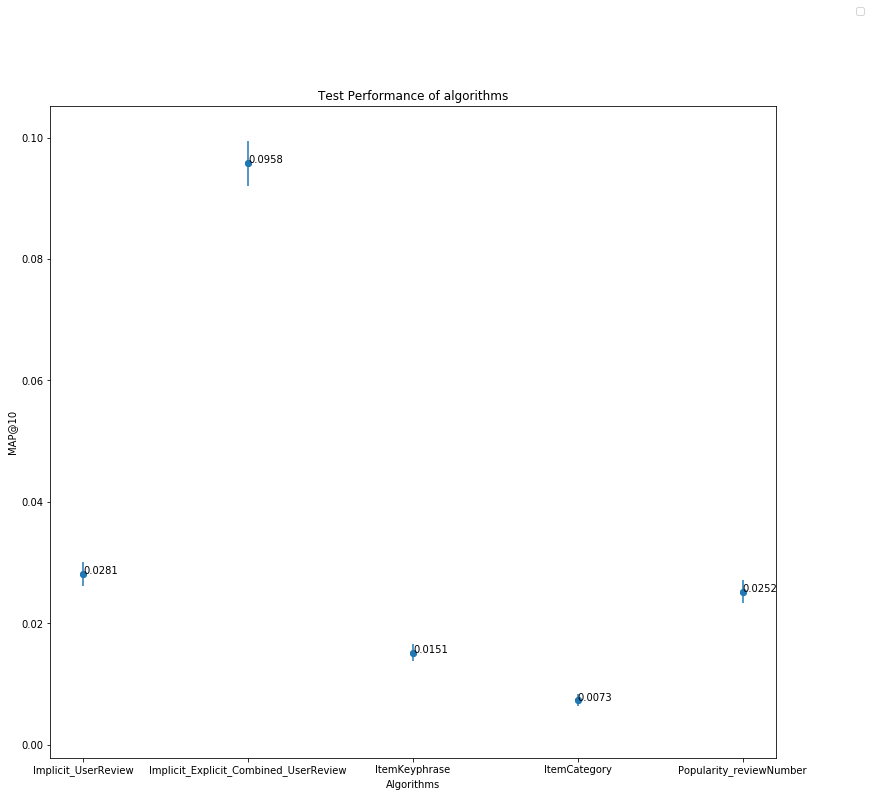

In [154]:
import matplotlib.pyplot as plt
listPrediction = testPerformance.items()

x1, y1 = zip(*listPrediction) # unpack a list of pairs into two tuples

x = []
y = []
err = []
for item in x1:
    x.append(item)
    
for item in y1:
    y.append(item[0])
    err.append(item[1])
    
plt.figure(figsize=(13,12))

plt.scatter(x,y)

plt.errorbar(x,y,yerr=err, linestyle="None", fmt='o')

for x2, y2 in zip(x, y): 
    plt.text(x2, y2, str(y2))
      
plt.title('Test Performance of algorithms')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.xlabel('Algorithms')
plt.ylabel('MAP@10')
plt.show()